# Credit cards fraud detection

https://www.kaggle.com/dalpozz/creditcardfraud

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation.

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

## Preprocessing

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('../data/fraud-prediction/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.shape

(284807, 31)

In [6]:
features = data.columns[data.columns != 'Class']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[features], data['Class'], 
                                                    test_size=0.2, random_state=42, stratify=data['Class'])

In [8]:
import sys
sys.path.append('..')
import warnings
warnings.simplefilter('ignore')
from experiment import Experiment
from xgboost_experiment import XGBExperiment
from lightgbm_experiment import LGBExperiment
from catboost_experiment import CABExperiment

In [10]:
X_train, y_train, X_test, y_test, cat_cols = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), []

In [11]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def run_default(Experiment, title, n_estimators):
    
    experiment = Experiment(learning_task, n_estimators)
    cv_pairs, (dtrain, dtest), X_test_preprocessed = experiment.split_and_preprocess(X_train.copy(), y_train, 
                                                                X_test.copy(), y_test, 
                                                                cat_cols, n_splits=5)
 
    default_cv_result = experiment.run_cv(cv_pairs)
    experiment.print_result(default_cv_result, 'Default {} result on cv'.format(title))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    default_test_losses = []
    fscores = {0: [], 1: [], 'average': []}
    durations = []
    
    for seed in range(5):
        test_result = experiment.run_test(dtrain, dtest, X_test_preprocessed, params=default_cv_result['params'],
                                          n_estimators=default_cv_result['best_n_estimators'], seed=seed)
        default_test_losses.append(test_result['loss'])
        preds, duration = test_result['preds'], test_result['eval_time']
        labels = np.array([1 if p > 0.5 else 0 for p in preds])
        metrics = precision_recall_fscore_support(y_test, labels)
        for cl in xrange(2):
            fscores[cl].append(metrics[2][cl])
        fscores['average'].append(precision_recall_fscore_support(y_test, labels,  average='weighted')[2])
        durations.append(duration)
        
        if seed == 4:
            print '\n', classification_report(y_test, labels)
        
        print 'For seed=%d Test\'s %s : %.5f' % (seed, experiment.metric, default_test_losses[-1])
    print '\nTest\'s %s mean: %.5f, Test\'s %s std: %.5f' % (experiment.metric, np.mean(default_test_losses),
                                                             experiment.metric, np.std(default_test_losses))
    print '\nMean f-score for class 0: {:.5f}\nMean f-score for class 1: {:.5f}'.format(np.mean(fscores[0]), np.mean(fscores[1]))
    print '\nMean average f-score: {:.5f}'.format(np.mean(fscores['average']))
                                  
    print '\n\nDurations:\n{}'.format(durations)
    print 'Average runtime: {:.3f} sec'.format(np.mean(durations))
    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
    
    return ([np.mean(default_test_losses)] + [np.mean(fscores[cl]) for cl in fscores.keys()] + \
            [np.mean(durations), default_cv_result['best_n_estimators']])

In [12]:
learning_task = 'classification'

## XGBoost

In [14]:
%%time
xgb_default_test_result = run_default(XGBExperiment, "XGBoost", n_estimators=100)

Default XGBoost result on cv:

logloss = 0.0026382
best_n_estimators = 32
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.00237
For seed=1 Test's logloss : 0.00237
For seed=2 Test's logloss : 0.00237
For seed=3 Test's logloss : 0.00237

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.92      0.81      0.86        98

avg / total       1.00      1.00      1.00     56962

For seed=4 Test's logloss : 0.00237

Test's logloss mean: 0.00237, Test's logloss std: 0.00000

Mean f-score for class 0: 0.99977
Mean f-score for class 1: 0.85870

Mean average f-score: 0.99953


Durations:
[6.012451887130737, 6.73032808303833, 6.54851102828979

## LightGBM

In [15]:
%%time
lgb_default_test_result = run_default(LGBExperiment, "LightGBM", n_estimators=100)

Default LightGBM result on cv:

logloss = 0.00261191256798
best_n_estimators = 100
params = {'num_leaves': 127, 'verbose': -1, 'bagging_seed': 3, 'learning_rate': 0.1, 'data_random_seed': 1, 'min_data_in_leaf': 100, 'bagging_fraction': 1.0, 'metric': 'binary_logloss', 'feature_fraction_seed': 2, 'lambda_l1': 0, 'bagging_freq': 1, 'lambda_l2': 0, 'max_bin': 255, 'objective': 'binary', 'drop_seed': 4, 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.00238
For seed=1 Test's logloss : 0.00238
For seed=2 Test's logloss : 0.00238
For seed=3 Test's logloss : 0.00238

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.93      0.80      0.86        98

avg / total       1.00      1.00      1.00     56962

For seed=4 Test's logloss : 0.00238

Test's logloss mean: 0.00238, Test's logloss std: 0.00000

Mean f-score for class 0: 0.99

## CatBoost

In [16]:
%%time
cab_default_test_result = run_default(CABExperiment, "CatBoost", n_estimators=100)

Default CatBoost result on cv:

logloss = 0.0029524493682
best_n_estimators = 100
params = {'rsm': 1.0, 'random_seed': 0, 'verbose': False, 'learning_rate': 0.03, 'ctr_border_count': 16, 'ctr_description': ['Borders', 'Counter'], 'depth': 6, 'fold_len_multiplier': 2, 'loss_function': 'Logloss', 'iterations': 100, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'gradient_iterations': 10, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.00245
For seed=1 Test's logloss : 0.00246
For seed=2 Test's logloss : 0.00244
For seed=3 Test's logloss : 0.00243

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.95      0.78      0.85        98

avg / total       1.00      1.00      1.00     56962

For seed=4 Test's logloss : 0.00248

Test's logloss mean: 0.00245, Test's logloss std: 0.00002

Mean f-score for class 0: 0.99977
Mean f

## Comparing

In [20]:
results = [
    cab_default_test_result,
    xgb_default_test_result,
    lgb_default_test_result,
]
res_df = pd.DataFrame(np.array(results), 
                      columns=['LogLoss', 'F-measure_Class0', 'F-measure_Class1', 'F-measure', 'MeanRuntime', 'NumberOfTrees'], 
            index = ['Default CatBoost', 'Default XGBoost', 'Default LightGBM'],
                     )
res_df['NumberOfTrees'] = res_df['NumberOfTrees'].astype(int)
res_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.00245,0.99977,0.85455,0.99952,27.84582,100
Default XGBoost,0.00237,0.99977,0.85870,0.99953,6.34430,32
Default LightGBM,0.00238,0.99977,0.85714,0.99953,1.95497,100


In [21]:
res_df.to_csv('../results/results_credits.csv')

In [23]:
res_df = pd.read_csv('../results/results_credits.csv', index_col=0)
res_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.00245,0.99977,0.85455,0.99952,27.84582,100
Default XGBoost,0.00237,0.99977,0.85870,0.99953,6.34430,32
Default LightGBM,0.00238,0.99977,0.85714,0.99953,1.95497,100


###### LogLoss

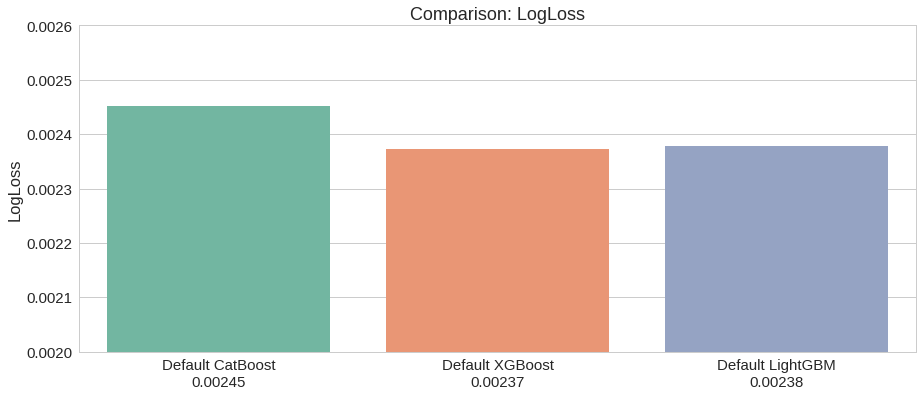

In [25]:
%pylab inline
import seaborn as sns

names = ['%s\n%.5f' % (name, loss) for name, loss in zip(res_df.index, res_df['LogLoss'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="LogLoss", data=res_df, palette='Set2')
g.set(ylim=(0.002, 0.0026), ylabel='LogLoss', title='Comparison: LogLoss')
_ = g.set_xticklabels(names)

###### F-measure for minority class

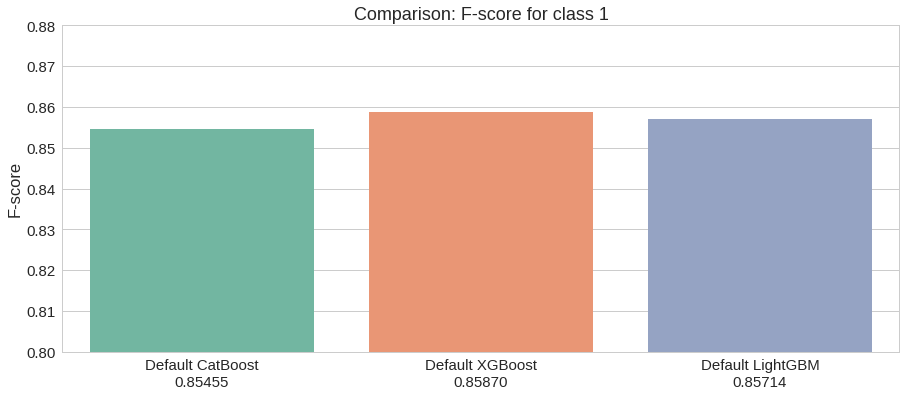

In [26]:
names = ['%s\n%.5f' % (name, loss) for name, loss in zip(res_df.index, res_df['F-measure_Class1'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="F-measure_Class1", data=res_df, palette='Set2')
g.set(ylim=(0.8, 0.88), ylabel='F-score', title='Comparison: F-score for class 1')
_ = g.set_xticklabels(names)

Очень осмысленный график.

##### Average runtime

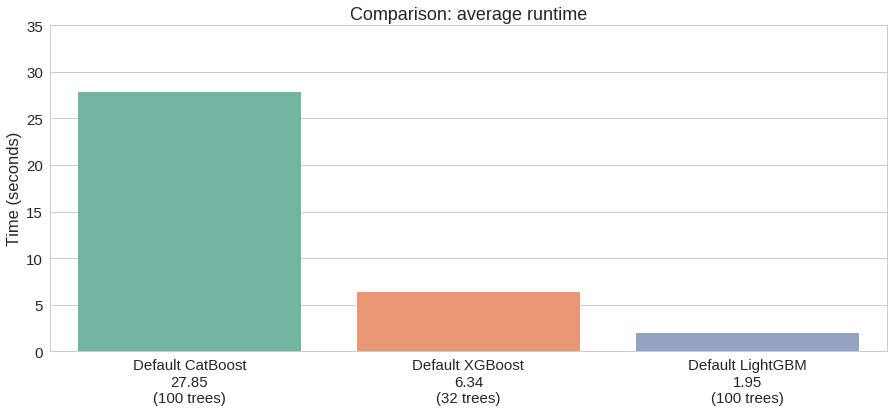

In [27]:
names = ['{}\n{:.2f}\n({} trees)'.format(name, loss, tree) for name, loss, tree in 
         zip(res_df.index, res_df['MeanRuntime'], res_df['NumberOfTrees'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="MeanRuntime", data=res_df, palette='Set2')
g.set(ylim=(0., 35), ylabel='Time (seconds)', title='Comparison: average runtime')
_ = g.set_xticklabels(names)

In [28]:
print '\n\nIn this task CatBoost is on average\n\n\t\t{:.1f} times slower than XGBoost \n\t\t{:.1f} times slower than LightGBM\n'.format(
    res_df['MeanRuntime'][0]/res_df['MeanRuntime'][1],
    res_df['MeanRuntime'][0]/res_df['MeanRuntime'][2]
)



In this task CatBoost is on average

		4.4 times slower than XGBoost 
		14.2 times slower than LightGBM



Пока что Кэтбуст проигрывает - дает чуть худшие результаты, и при этом работает в разы медленнее.

#### Попробуем дать Кэтбусту второй шанс 
и увеличим максимальное число деревьев до пяти тысяч, как делал Яндекс

## XGBoost

In [15]:
%%time
xgb_result_moretrees = run_default(XGBExperiment, "XGBoost", n_estimators=5000)

Default XGBoost result on cv:

logloss = 0.0026382
best_n_estimators = 32
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.00237
For seed=1 Test's logloss : 0.00237
For seed=2 Test's logloss : 0.00237
For seed=3 Test's logloss : 0.00237

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.92      0.81      0.86        98

avg / total       1.00      1.00      1.00     56962

For seed=4 Test's logloss : 0.00237

Test's logloss mean: 0.00237, Test's logloss std: 0.00000

Mean f-score for class 0: 0.99977
Mean f-score for class 1: 0.85870

Mean average f-score: 0.99953


Durations:
[5.656154155731201, 5.520355939865112, 5.5816259384155

## LightXGB

In [32]:
%%time
lgb_result_moretrees = run_default(LGBExperiment, "LightGBM", n_estimators=5000)

Default LightGBM result on cv:

logloss = 0.00251888688265
best_n_estimators = 202
params = {'num_leaves': 127, 'verbose': -1, 'bagging_seed': 3, 'learning_rate': 0.1, 'data_random_seed': 1, 'min_data_in_leaf': 100, 'bagging_fraction': 1.0, 'metric': 'binary_logloss', 'feature_fraction_seed': 2, 'lambda_l1': 0, 'bagging_freq': 1, 'lambda_l2': 0, 'max_bin': 255, 'objective': 'binary', 'drop_seed': 4, 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.00236
For seed=1 Test's logloss : 0.00236
For seed=2 Test's logloss : 0.00236
For seed=3 Test's logloss : 0.00236

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.92      0.81      0.86        98

avg / total       1.00      1.00      1.00     56962

For seed=4 Test's logloss : 0.00236

Test's logloss mean: 0.00236, Test's logloss std: 0.00000

Mean f-score for class 0: 0.99

## CatBoost

In [13]:
%%time
cab_result_moretrees = run_default(CABExperiment, "CatBoost", n_estimators=5000)

Default CatBoost result on cv:

logloss = 0.002514291359
best_n_estimators = 723
params = {'rsm': 1.0, 'random_seed': 0, 'verbose': False, 'learning_rate': 0.03, 'ctr_border_count': 16, 'ctr_description': ['Borders', 'Counter'], 'depth': 6, 'fold_len_multiplier': 2, 'loss_function': 'Logloss', 'iterations': 5000, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'gradient_iterations': 10, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.00217
For seed=1 Test's logloss : 0.00219
For seed=2 Test's logloss : 0.00210
For seed=3 Test's logloss : 0.00226

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.96      0.80      0.87        98

avg / total       1.00      1.00      1.00     56962

For seed=4 Test's logloss : 0.00219

Test's logloss mean: 0.00218, Test's logloss std: 0.00005

Mean f-score for class 0: 0.99979
Mean f

In [33]:
results_moretrees = [
    cab_result_moretrees,
    xgb_result_moretrees,
    lgb_result_moretrees,
]
more_df = pd.DataFrame(np.array(results_moretrees), 
                      columns=['LogLoss', 'F-measure_Class0', 'F-measure_Class1', 'F-measure',
                               'MeanRuntime', 'NumberOfTrees'], 
            index = ['Default CatBoost', 'Default XGBoost', 'Default LightGBM']
                      )
more_df['NumberOfTrees'] = more_df['NumberOfTrees'].astype(int)
more_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.00218,0.99979,0.86792,0.99956,88.28165,723
Default XGBoost,0.00237,0.99977,0.85870,0.99953,5.55644,32
Default LightGBM,0.00236,0.99977,0.85870,0.99953,3.09992,202


In [34]:
more_df.to_csv('../results/results_credits_moretrees.csv')

In [19]:
#more_df = pd.read_csv('../results/results_credits_moretrees.csv', index_col=0)
#more_df.round(5)

###### LogLoss

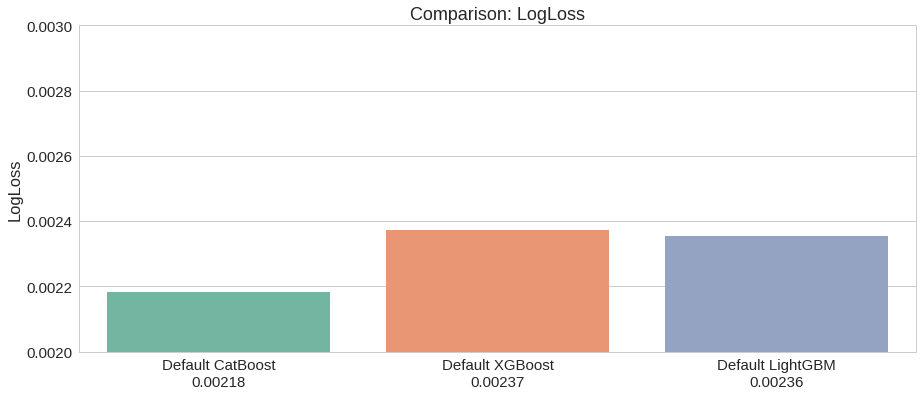

In [35]:
names = ['%s\n%.5f' % (name, loss) for name, loss in zip(more_df.index, more_df['LogLoss'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="LogLoss", data=more_df, palette='Set2')
g.set(ylim=(0.002, 0.003), ylabel='LogLoss', title='Comparison: LogLoss')
_ = g.set_xticklabels(names)

###### F-measure for minority class

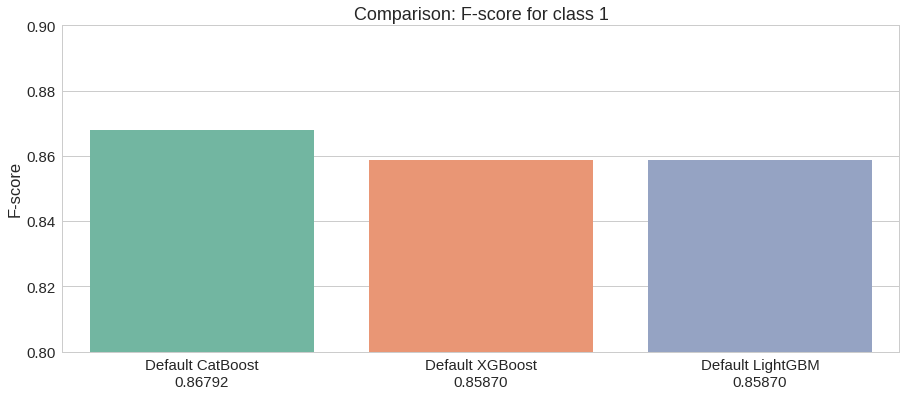

In [28]:
names = ['%s\n%.5f' % (name, loss) for name, loss in zip(more_df.index, more_df['F-measure_Class1'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="F-measure_Class1", data=more_df, palette='Set2')
g.set(ylim=(0.8, 0.9), ylabel='F-score', title='Comparison: F-score for class 1')
_ = g.set_xticklabels(names)

##### Average runtime

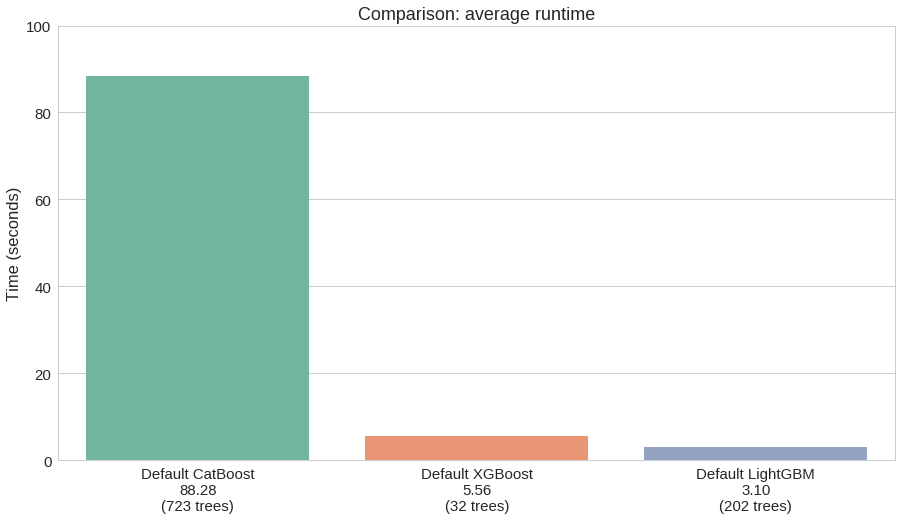

In [37]:
names = ['{}\n{:.2f}\n({} trees)'.format(name, loss, tree) for name, loss, tree in 
         zip(more_df.index, more_df['MeanRuntime'], more_df['NumberOfTrees'])]

plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="MeanRuntime", data=more_df, palette='Set2')
g.set(ylim=(0., 100), ylabel='Time (seconds)', title='Comparison: average runtime')
_ = g.set_xticklabels(names)